<div>
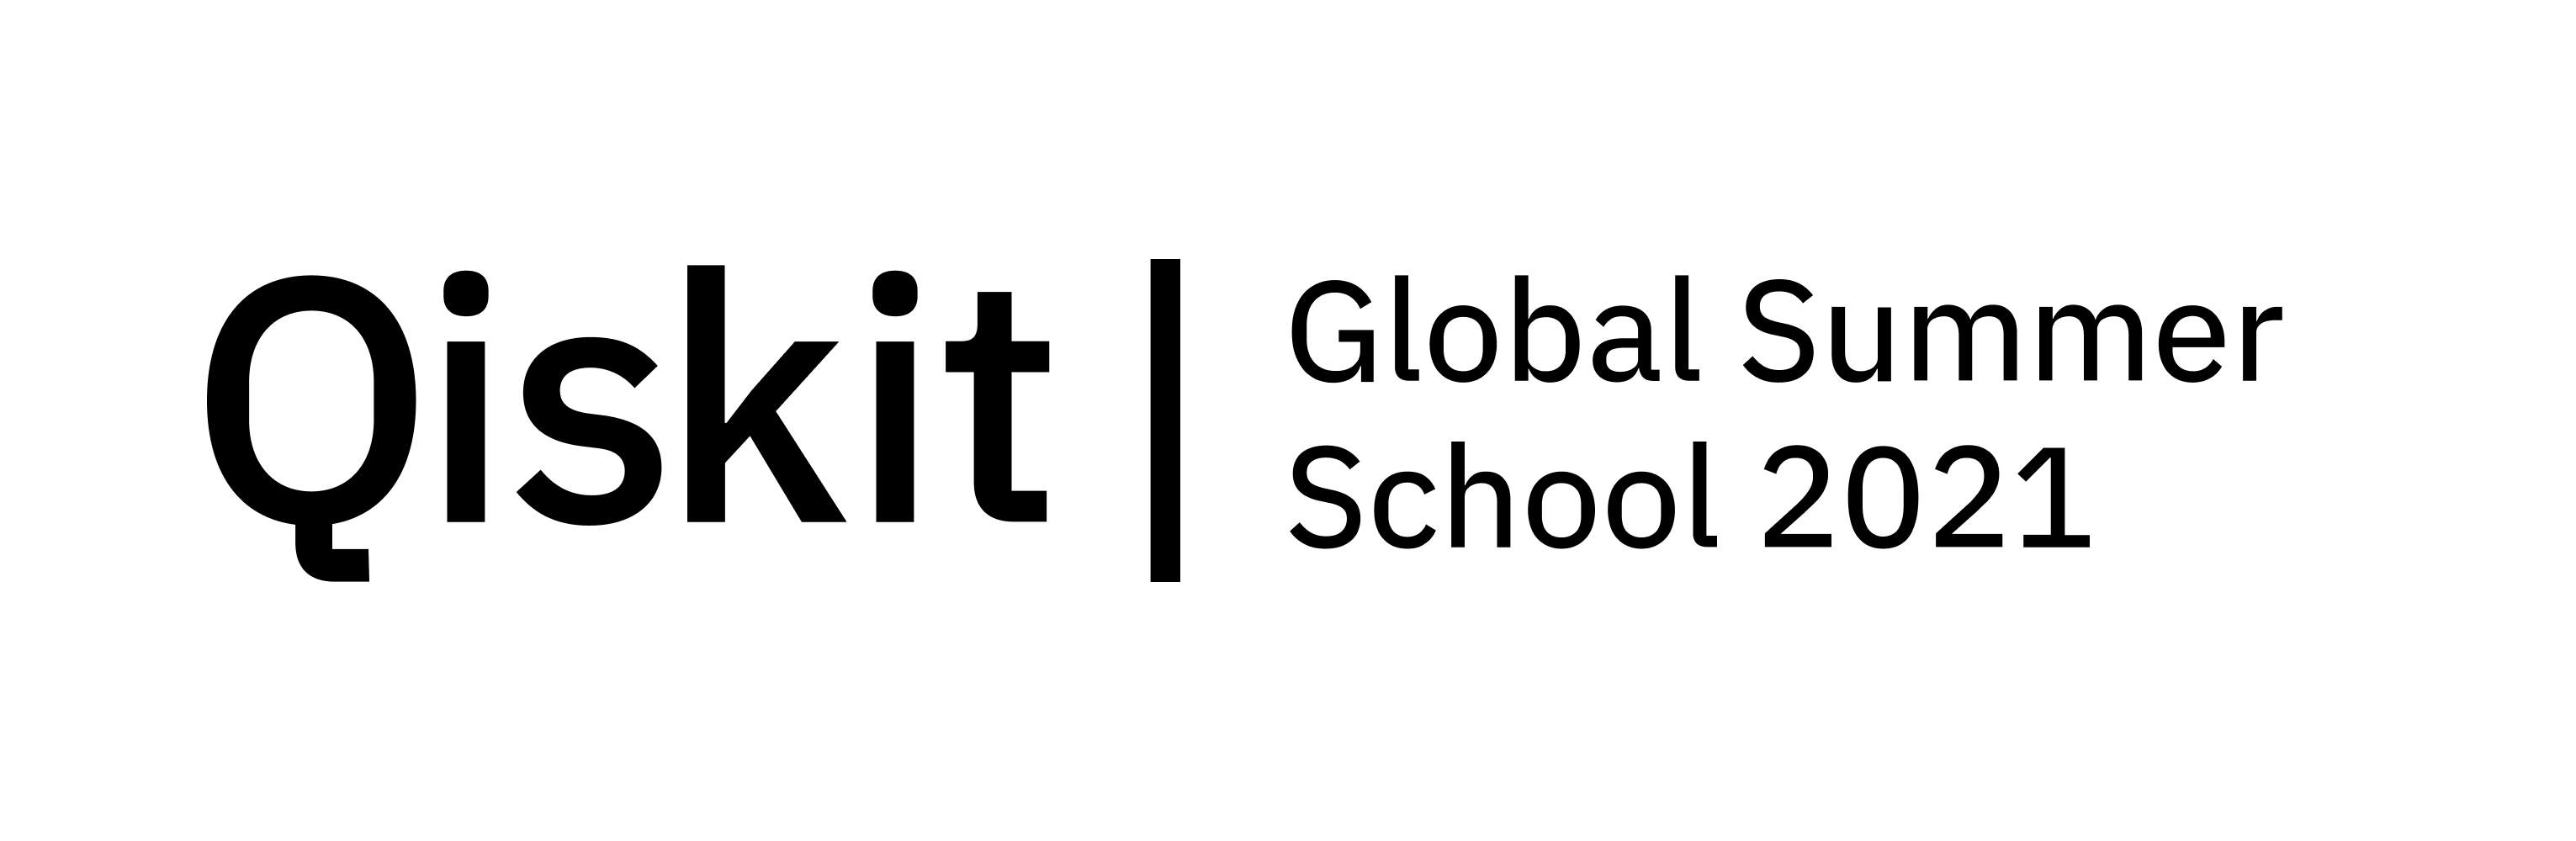
</div>

In this lab, you will see how noise affects a typical parameterized quantum circuit used in machine learning using quantum process tomography. 

<div class="alert alert-danger" role="alert">
For grading purposes, please specify all simulator arguments (<i>noise_model=noise_thermal, seed_simulator=3145, seed_transpiler=3145, shots=8192</i>) in the <b><i>execute</i></b> function.
</div>

In [1]:
# General tools
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Circuit Functions
from qiskit import  execute,QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile
import qiskit.quantum_info as qi

# Tomography functions
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

import warnings 
warnings.filterwarnings('ignore')

### Question 1
- Make this Quantum Circuit

<div>
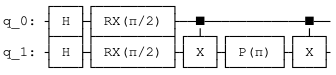
</div>

In [2]:
target = QuantumCircuit(2)

target.h(0)
target.h(1)
target.rx(np.pi/2, 0)
target.rx(np.pi/2, 1)
target.cx(0, 1)
target.rz(np.pi, 1)
target.cx(0, 1)

target_unitary = qi.Operator(target)

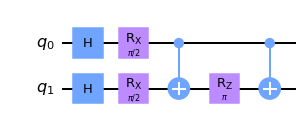

In [3]:
target.draw('mpl')

In [4]:
np.round(target_unitary.data, 3)

array([[-0.5-0.j ,  0. -0.5j,  0. -0.5j,  0.5-0.j ],
       [ 0.5+0.j , -0. -0.5j,  0. +0.5j,  0.5-0.j ],
       [ 0.5+0.j ,  0. +0.5j, -0. -0.5j,  0.5-0.j ],
       [-0.5-0.j , -0. +0.5j, -0. +0.5j,  0.5-0.j ]])

In [5]:
from qc_grader import grade_lab5_ex1

# Note that the grading function is expecting a quantum circuit with no measurements
grade_lab5_ex1(target)

Submitting your answer for lab5/ex1. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


# Quantum Process Tomography with Only Shot Noise
Here we will now use the `qasm_simulator` to simulate a Quantum Process Tomography Circuit

### Question 2a
- Using the Process Tomography Circuits function built into qiskit, create the set of circuits to do quantum process tomography and simulation with a qasm simulator (with shot noise only). For this please use the execute function of the QPT Circuits with `seed_simulator=3145`, `seed_transpiler=3145` and `shots=8192`. 


- _Hint: The appropriate function, <a href="https://qiskit.org/documentation/stubs/qiskit.ignis.verification.process_tomography_circuits.html">process_tomography_circuits</a>, has been imported above. When complete you should have a total of 144 circuits that are given to the `qasm_simulator` via the `execute` function. You can find out the number of circuits created using `len(qpt_circs)`._

In [34]:
simulator = Aer.get_backend('qasm_simulator')
qpt_circs = process_tomography_circuits(target, measured_qubits=[0,1])
qpt_job = execute(qpt_circs,simulator,seed_simulator=3145,seed_transpiler=3145,shots=8192)
qpt_result = qpt_job.result()

In [35]:
len(qpt_circs)

144

### Question 2b
- Using a least squares fitting method for the Process Tomography Fitter, determine the fidelity of your target unitary



- _Hint: First use the <a href="https://qiskit.org/documentation/stubs/qiskit.ignis.verification.ProcessTomographyFitter.html">ProcessTomographyFitter</a> function above to process the results from question 2a and use ProcessTomographyFitter.fit(method='....') to extract the "Choi Matrix", which effectively describes the measured unitary operation.  From here you will use the <a href="https://qiskit.org/documentation/stubs/qiskit.quantum_info.average_gate_fidelity.html#qiskit.quantum_info.average_gate_fidelity">average_gate_fidelity</a> function from the quantum information module to extract the achieved fidelity of your results_

In [36]:
qpt_tomo = ProcessTomographyFitter(qpt_result, qpt_circs)
qpt_lstsq = qpt_tomo.fit(method='lstsq')
qpt_lstsq

Choi([[ 2.51101114e-01+0.00000000e+00j, -2.47327284e-01-6.76316677e-05j,
       -2.47889589e-01+2.42534281e-04j,  2.48694256e-01+1.96694414e-04j,
       -4.08829330e-03-2.49382499e-01j, -1.61689837e-03-2.48056060e-01j,
        3.52076939e-03+2.48205722e-01j,  3.02897423e-03+2.49982014e-01j,
       -1.31306126e-03-2.48268426e-01j, -8.72851602e-05+2.48869549e-01j,
       -1.38226605e-03-2.51276921e-01j,  2.00138617e-03+2.48468499e-01j,
       -2.47498518e-01+1.65990428e-04j, -2.47567283e-01+4.12794568e-03j,
       -2.50379825e-01+1.91307321e-03j, -2.48160574e-01+3.32030963e-03j],
      [-2.47327284e-01+6.76316677e-05j,  2.44726763e-01+0.00000000e+00j,
        2.45537408e-01-1.70792870e-04j, -2.45685255e-01-1.60556810e-04j,
        3.66542848e-03+2.46817501e-01j,  2.58192642e-03+2.46245042e-01j,
       -3.99511872e-03-2.45428235e-01j, -3.33244478e-03-2.47442362e-01j,
        1.41134752e-03+2.45403351e-01j,  1.10504969e-04-2.46874307e-01j,
        2.50077833e-03+2.47277678e-01j, -2.4489959

In [37]:
fidelity = qi.average_gate_fidelity(qpt_lstsq, target_unitary)

In [48]:
from qc_grader import grade_lab5_ex2

# Note that the grading function is expecting a floating point number
grade_lab5_ex2(fidelity)

Submitting your answer for lab5/ex2. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


# Quantum Process Tomography with a T1/T2 Noise Model
For the sake of consistency, let's set some values to characterize the duration of our gates and T1/T2 times:

In [10]:
# T1 and T2 values for qubits 0-3
T1s = [15000, 19000, 22000, 14000]
T2s = [30000, 25000, 18000, 28000]

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

In [11]:
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel

### Question 3
- Using the Thermal Relaxation Error model built into qiskit, define `u1`,`u2`,`u3`, `cx`, `measure` and `reset` errors using the values for qubits 0-3 defined above, and build a thermal noise model.


- _Hint: The Qiskit tutorial on <a href="https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/simulators/3_building_noise_models.ipynb">building noise models</a>  will prove to be useful, particularly where they add quantum errors for `u1`,`u2`,`u3`,`cx`, `reset`, and `measure` errors (please include all of these)._

In [20]:
# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()

for j in range(4):
    noise_thermal.add_quantum_error(errors_measure[j], 'measure', [j])
    noise_thermal.add_quantum_error(errors_u1[j], 'u1', [j])
    noise_thermal.add_quantum_error(errors_u2[j], 'u2', [j])
    noise_thermal.add_quantum_error(errors_u3[j], 'u3', [j])
    noise_thermal.add_quantum_error(errors_reset[j], 'reset', [j])
    for i in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][i], 'cx', [j,i])

In [21]:
from qc_grader import grade_lab5_ex3

# Note that the grading function is expecting a NoiseModel
grade_lab5_ex3(noise_thermal)

Submitting your answer for lab5/ex3. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [29]:
print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u3', 'measure', 'u2', 'cx', 'reset']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


### Question 4.
- Get a QPT fidelity using the noise model,but without using any error mitigation techniques.  Again, use `seed_simulator=3145`, `seed_transpiler=3145` and `shots=8192` for the `execute` function



- _Hint: The process here should be very similar to that in question 2a/b, except you will need to ensure you include the noise model from question 3 in the `execute` function_

In [32]:
np.random.seed(0)

noisy_qpt_job = execute(qpt_circs,simulator,seed_simulator=3145,seed_transpiler=3145,shots=8192, noise_model=noise_thermal)
noisy_qpt_result = noisy_qpt_job.result()

noisy_qpt_tomo = ProcessTomographyFitter(noisy_qpt_result, qpt_circs)
noisy_qpt_lstsq = noisy_qpt_tomo.fit(method='lstsq')
noisy_fidelity = qi.average_gate_fidelity(noisy_qpt_lstsq, target_unitary)

In [33]:
from qc_grader import grade_lab5_ex4

# Note that the grading function is expecting a floating point number
grade_lab5_ex4(noisy_fidelity)

Submitting your answer for lab5/ex4. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [38]:
print('Fidelity {}'.format(fidelity))
print('Noisy fidelity {}'.format(noisy_fidelity))

Fidelity 0.9926697818280223
Noisy fidelity 0.895962996242963


### Question 5. 
- Use the `complete_meas_cal` function built into qiskit and apply to the QPT results in the previous question. For both, use the `execute` function and `seed_simulator=3145`, `seed_transpiler=3145` and `shots=8192`. Also include the noise model from question 3 in the `execute` function.


- *Hint: The Qiskit textbook has a very good chapter on <a href="https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html">`readout error mitigation`</a>. Specifically, you will want to use the <a href="https://qiskit.org/documentation/stubs/qiskit.ignis.mitigation.complete_meas_cal.html">`complete_meas_cal`</a>  function to generate the desired set of circuits to create the calibration matrix with <a href="https://qiskit.org/documentation/stubs/qiskit.ignis.mitigation.CompleteMeasFitter.html">`CompleteMeasureFitter`</a> function. This can then be used to generate a correction matrix <a href="https://qiskit.org/documentation/stubs/qiskit.ignis.mitigation.CompleteMeasFitter.html#qiskit.ignis.mitigation.CompleteMeasFitter.filter">`meas_filter`</a>. Apply this function to the results from question 4.*

In [55]:
np.random.seed(0)

meas_cal_circs, state_labels = complete_meas_cal(qubit_list = [0,1])
meas_cal_job = execute(meas_cal_circs, simulator, seed_simulator=3145,seed_transpiler=3145,shots=8192, noise_model=noise_thermal)
meas_cal_result = meas_cal_job.result()
len(meas_cal_circs)

4

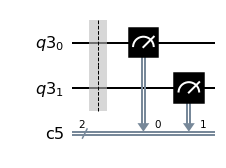

In [56]:
meas_cal_circs[0].draw('mpl')

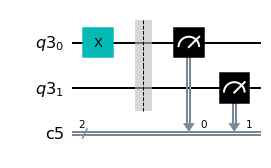

In [57]:
meas_cal_circs[1].draw('mpl')

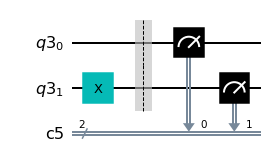

In [58]:
meas_cal_circs[2].draw('mpl')

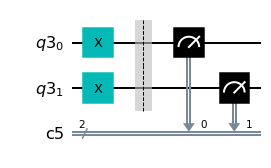

In [59]:
meas_cal_circs[3].draw('mpl')

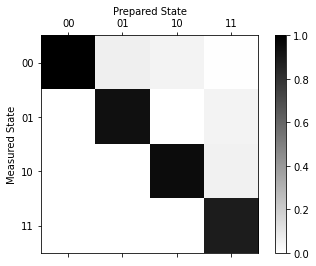

In [65]:
meas_fitter = CompleteMeasFitter(meas_cal_result, state_labels)
meas_filter = meas_fitter.filter
meas_fitter.plot_calibration()

We can see that the '00' is the only initial state that has no associated error

In [66]:
mitigated_noisy_result = meas_filter.apply(noisy_qpt_result)
mitigated_noisy_qpt_tomo = ProcessTomographyFitter(mitigated_noisy_result, qpt_circs)
mitigated_noisy_qpt_lstsq = mitigated_noisy_qpt_tomo.fit(method='lstsq')
mitigated_noisy_fidelity = qi.average_gate_fidelity(mitigated_noisy_qpt_lstsq, target_unitary)

In [67]:
from qc_grader import grade_lab5_ex5

# Note that the grading function is expecting a floating point number
grade_lab5_ex5(mitigated_noisy_fidelity)

Submitting your answer for lab5/ex5. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [68]:
print('Fidelity {}'.format(fidelity))
print('Noisy fidelity {}'.format(noisy_fidelity))
print('Mitigated noisy fidelity {}'.format(mitigated_noisy_fidelity))

Fidelity 0.9926697818280223
Noisy fidelity 0.895962996242963
Mitigated noisy fidelity 0.9599277489899063


### Exploratory Question 6.
- Test how the gate fidelity depends on the CX duration by running noise models with varying cx durations (but leaving everything else fixed).  

(Note: this would ideally be done using the scaling technique discussed in the previous lecture, but due to backend availability limitations we are instead demonstrating the effect by adjusting duration of the CX itself.  This is not exactly how this is implemented on the hardware itself as the gates are not full CX gates.)

In [69]:
fids = []
mit_fids = []
time_cxs = np.linspace(50,400,15)
time_measure = 1000

for ii, time_cx in enumerate(time_cxs):
    print(ii)
    
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]

    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                 thermal_relaxation_error(t1b, t2b, time_cx))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]
    
    # add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(4):
        noise_thermal.add_quantum_error(errors_measure[j], 'measure', [j])
        noise_thermal.add_quantum_error(errors_u1[j], 'u1', [j])
        noise_thermal.add_quantum_error(errors_u2[j], 'u2', [j])
        noise_thermal.add_quantum_error(errors_u3[j], 'u3', [j])
        noise_thermal.add_quantum_error(errors_reset[j], 'reset', [j])
        for i in range(4):
            noise_thermal.add_quantum_error(errors_cx[j][i], 'cx', [j,i])
            
    np.random.seed(0)

    qpt_circs = process_tomography_circuits(target, measured_qubits=[0,1])
    noisy_qpt_job = execute(qpt_circs,simulator,seed_simulator=3145,seed_transpiler=3145,shots=8192, noise_model=noise_thermal)
    noisy_qpt_result = noisy_qpt_job.result()

    # noisy fidelity
    noisy_qpt_tomo = ProcessTomographyFitter(noisy_qpt_result, qpt_circs)
    noisy_qpt_lstsq = noisy_qpt_tomo.fit(method='lstsq')
    noisy_fidelity = qi.average_gate_fidelity(noisy_qpt_lstsq, target_unitary)
    
    # mitigated noisy fidelity
    meas_fitter = CompleteMeasFitter(meas_cal_result, state_labels)
    meas_filter = meas_fitter.filter
    
    mitigated_noisy_result = meas_filter.apply(noisy_qpt_result)
    mitigated_noisy_qpt_tomo = ProcessTomographyFitter(mitigated_noisy_result, qpt_circs)
    mitigated_noisy_qpt_lstsq = mitigated_noisy_qpt_tomo.fit(method='lstsq')
    mitigated_noisy_fidelity = qi.average_gate_fidelity(mitigated_noisy_qpt_lstsq, target_unitary)
    print(noisy_fidelity, mitigated_noisy_fidelity)
    fids.append(noisy_fidelity)
    mit_fids.append(mitigated_noisy_fidelity)

0
0.9174767270482942 0.9837505777938539
1
0.915147432366892 0.9814332288859593
2
0.9130411850327231 0.9792122759388405
3
0.910686313055888 0.976498956694623
4
0.9083670780147954 0.9738058127548029
5
0.9061918123389262 0.9713798389217864
6
0.9044745559960357 0.9694199880254437
7
0.9021085431479163 0.9667660958081639
8
0.9002689855045822 0.9647206399436546
9
0.8981317673908051 0.962380841641218
10
0.895962996242963 0.9599277489961345
11
0.8936084513354878 0.9573301307411128
12
0.8913122945132381 0.954724627829383
13
0.8894103615487923 0.9525464310419876
14
0.8871870450634292 0.9500840626317549


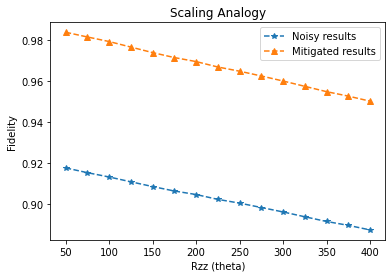

In [72]:
plt.title('Scaling Analogy')
plt.xlabel('Rzz (theta)')
plt.ylabel('Fidelity')
plt.plot(time_cxs, fids, '*--', label='Noisy results')
plt.plot(time_cxs, mit_fids, '^--', label='Mitigated results')
plt.legend()
plt.show()